# Import libraries

In [43]:
import matplotlib.pyplot as plt
import numpy.matlib
import numpy as np
import scipy
from scipy.cluster.hierarchy import DisjointSet
from scipy.stats import truncnorm
import math

from network_def import *
from wk1_sampling import *
from wk1_histogram_plot import *
from wk1_6_complexity import *
from wk1_7_component import *
from wk2_1_config_model import *
from wk3_2_crit_thres import *
from wk3_4_SIR_djset import *



# Distributions of $\lambda_i$ for individual nodes

Generation of $\lambda_i$ arrays for each given $\lambda$ mean.

In [44]:
def node_lambda(n, mean, dist=None):
    """Generate the susceptibility for each node in the network."""
    # variance scale with mean value
    
    if dist is None:
        lambda_i = np.full(n, mean)
    elif dist == "uniform":
        lambda_i = np.random.uniform(0, 2*mean, n)
    elif dist == "normal":
        std = mean / 3
        lambda_i = np.random.normal(mean, std, n)
        lambda_i = np.clip(lambda_i, 0, 2*mean)
    elif dist == "exponential":
        lambda_i = np.random.exponential(mean, n)
        lambda_i = np.clip(lambda_i, 0, 1) # FIXME: after clipping, the mean is shifted to the left slightly
    else:
        raise ValueError("Invalid distribution type.")
    return lambda_i

def lambda_mat_gen(n, means, dist=None):
    """Generate the susceptibility matrix for each node in the network, for each value of lambda mean."""
    lambda_mat = np.empty((len(means),n))
    for idx, mean in enumerate(means):
        lambda_i = node_lambda(n, mean, dist)
        lambda_mat[idx] = lambda_i

    return lambda_mat # shape (len(means), n)


Prediction from iterative calculations of $s_i$ probabilities.

In [45]:
#### TODO: Modified from wk3_2_crit_thres to account for variations in the susceptibility of nodes (different lambda_i for each node)
def compute_s_probs(network, lambdas, tol=1e-6, max_iter=1000):
    n = network.n
    assert len(lambdas) == n, "Length of lambdas must equal to the number of nodes."
    adj_ls = network.adj_ls
    
    s = np.random.rand(n)
    s_prev = np.zeros(n)

    for _ in range(max_iter):
        if np.allclose(s, s_prev, atol=tol):
            break
        s_prev = s.copy()

        for i in range(n):
            s_j = np.array([s_prev[j] for j in adj_ls[i]])
            lambda_i = lambdas[i]
            log_terms = np.log(1 - lambda_i + s_j * lambda_i)
            s[i] = np.exp(np.sum(log_terms))

    return s # shape (n,)

Empirical simulations using DisjointSet.

In [46]:
#### TODO: Modified from wk3_4_SIR_djset to account for variations in the susceptibility of nodes (different lambda_i for each node) --> directional edges
def SIR_djset_dir(n, edge_ls, lambdas):
    """Simulate the SIR model on the given network represented by disjoint set.
    Assume single seed node to be node 0."""

    C = DisjointSet(range(n))
    edge_lambdas = np.array([lambdas[edge[0]] for edge in edge_ls]) # FIXME: (Simplifications) Assume the first node in the edge is the sink node (i.e. the node that can be infected)
    prob_infect = np.random.binomial(1, edge_lambdas) # Randomly assign infection outcome to each edge based on probability lambda_i (i.e., susceptibility of the sink node)
    
    for idx, edge in enumerate(edge_ls):
        if prob_infect[idx] == 1:
            C.merge(edge[0], edge[1])

    return C.subset_size(0) # Assume node 0 is the seed node

Set up experiments

In [47]:
# parameters
n = 10000
mean = 20
dists = [None, "uniform", "normal", "exponential"]
lambda_means = np.array([0.01, 0.02, 0.03, 0.04, 0.05, 0.075, 0.1, 0.15, 0.2, 0.25])

In [48]:
network = config_graph_gen(n, deg_dist_poisson(n, mean))
edge_ls = network.edge_list()
edge_ls = np.array(edge_ls)
# Shuffle the edge list along the edge pair axis
edge_ls = np.random.permutation(edge_ls)


In [49]:
lambda_mats = np.empty((len(dists), len(lambda_means), n))
for idx, dist in enumerate(dists):
    lambda_mats[idx] = lambda_mat_gen(n, lambda_means, dist) # shape (len(lambda_means), n)

In [50]:
# Check that the mean is relatively consistent across different distributions
lambda_means_actual = np.mean(lambda_mats, axis=2)
print(lambda_means_actual)

[[0.01       0.02       0.03       0.04       0.05       0.075
  0.1        0.15       0.2        0.25      ]
 [0.00994918 0.01982358 0.0300267  0.039453   0.0500487  0.0750896
  0.10082602 0.14903359 0.19905047 0.25091861]
 [0.01002273 0.020011   0.03012605 0.03994772 0.04982484 0.07461302
  0.10006603 0.14897487 0.2006821  0.25002365]
 [0.00999521 0.02011455 0.03017908 0.04101369 0.04953555 0.07475743
  0.09938528 0.149787   0.19789762 0.24630209]]


In [51]:
print(lambda_mats[1, 4, :10])
print(np.mean(lambda_mats[1, 4, :]))

[0.035227   0.08338419 0.01726232 0.08812508 0.09738905 0.03871396
 0.00345367 0.01539798 0.05406433 0.06102952]
0.05004869789974862


Theoretical:

In [52]:
s_arys = np.zeros((len(dists), len(lambda_means)))


for idx1, dist in enumerate(dists): # loop over each particular distribution
    lambda_mat = lambda_mats[idx1] 
    s_ary = s_arys[idx1]
    print(f"Processing dist: {dist}")
    
    for idx2, lambda_mean in enumerate(lambda_means): # select a particular lambda_mean
        print(f"lambda_mean = {lambda_mean}\r")
        lambdas = lambda_mat[idx2] # for a particular lambda_mean, get the corresponding lambda_i for all nodes in the network
        # print(lambdas.shape,"samples:", lambdas[:10])
        
        s_i = compute_s_probs(network, lambdas)
        s_ary[idx2] = np.average(s_i) # average over all nodes
        # print(f"Dist = {dist}, lambda_mean = {lambda_mean}, s = {s_ary[idx2]}")

    print(f"Dist = {dist}, s = {s_ary}")
Nr_arys_theo = n * (1 - s_arys)

Processing dist: None
lambda_mean = 0.01
lambda_mean = 0.02
lambda_mean = 0.03
lambda_mean = 0.04
lambda_mean = 0.05
lambda_mean = 0.075
lambda_mean = 0.1
lambda_mean = 0.15
lambda_mean = 0.2
lambda_mean = 0.25
Dist = None, s = [0.99999965 0.9999979  0.99999215 0.99997773 0.91256766 0.39250079
 0.19497845 0.05867336 0.01990742 0.00710026]
Processing dist: uniform
lambda_mean = 0.01
lambda_mean = 0.02
lambda_mean = 0.03
lambda_mean = 0.04
lambda_mean = 0.05
lambda_mean = 0.075
lambda_mean = 0.1
lambda_mean = 0.15
lambda_mean = 0.2
lambda_mean = 0.25
Dist = uniform, s = [0.99999961 0.99999912 0.99999565 0.99998827 0.91428769 0.52168983
 0.34439711 0.21080373 0.14758001 0.11074821]
Processing dist: normal
lambda_mean = 0.01
lambda_mean = 0.02
lambda_mean = 0.03
lambda_mean = 0.04
lambda_mean = 0.05
lambda_mean = 0.075
lambda_mean = 0.1
lambda_mean = 0.15
lambda_mean = 0.2
lambda_mean = 0.25
Dist = normal, s = [0.99999963 0.99999904 0.9999941  0.99998165 0.9190029  0.44421538
 0.24500556 0

C:\Users\Sun Ruitong\AppData\Local\Temp\ipykernel_24140\2017681911.py:18: RuntimeWarning: divide by zero encountered in log
  log_terms = np.log(1 - lambda_i + s_j * lambda_i)


lambda_mean = 0.25
Dist = exponential, s = [0.99999998 0.9999997  0.99999955 0.99999819 0.92881244 0.64431643
 0.4886873  0.32509422 0.24809232 0.19582421]


In [57]:
# Data store 1:
# Nr_arys_theo = np.array([[3.58390187e-03, 2.18260270e-02, 8.38024797e-02, 2.57835281e-01, 9.23773792e+02, 8.06598930e+03, 9.42020311e+03, 9.80419665e+03, 9.93054364e+03], 
#                          [4.03927314e-03, 9.97570528e-03, 4.77433067e-02, 1.44114450e-01, 9.15229003e+02, 6.44989186e+03, 7.92367786e+03, 8.56591015e+03, 8.87225965e+03],
#                          [3.69227049e-03, 9.59461736e-03, 5.36946162e-02, 1.57161531e-01, 8.46966356e+02, 7.56607061e+03, 9.01585801e+03, 9.51488527e+03, 9.71293619e+03],
#                          [1.18795722e-03, 1.83912704e-03, 5.32576750e-03, 1.69301550e-02, 5.77993956e+02, 5.14556773e+03, 6.71280023e+03, 7.52918222e+03, 8.02006144e+03]])

# lambda_means_actual = np.array([[0.01,       0.02,       0.03,       0.04,       0.05,       0.1,
#   0.15,       0.2,        0.25      ],
#  [0.01005542, 0.01976755, 0.03004051, 0.03962072, 0.05014943, 0.09942733,
#   0.14937067, 0.20160109, 0.25130376],
#  [0.00997977, 0.01998708, 0.02991074, 0.04001799, 0.0498579,  0.10022147,
#   0.15005898, 0.19993539, 0.24918718],
#  [0.01015197, 0.02007289, 0.02988146, 0.03956198, 0.04968087, 0.09997815,
#   0.14868148, 0.19984373, 0.24595158]]) 

########################################################################################

# Data store 2:
# Nr_arys_theo = [[3.46539731e-03 2.09849811e-02 7.85452338e-02 2.22742855e-01
#   8.74323360e+02 6.07499212e+03 8.05021549e+03 9.41326636e+03
#   9.80092578e+03 9.92899745e+03]
#  [3.89391911e-03 8.78785932e-03 4.34636129e-02 1.17281605e-01
#   8.57123094e+02 4.78310170e+03 6.55602885e+03 7.89196266e+03
#   8.52419990e+03 8.89251787e+03]
#  [3.69901455e-03 9.62130071e-03 5.89585356e-02 1.83481096e-01
#   8.09970983e+02 5.55784624e+03 7.54994440e+03 8.98812004e+03
#   9.51271442e+03 9.73245238e+03]
#  [2.40462510e-04 2.96974370e-03 4.46671283e-03 1.81181255e-02
#   7.11875604e+02 3.55683569e+03 5.11312702e+03 6.74905781e+03
#   7.51907682e+03 8.04175786e+03]]

# lambda_means_actual = [[0.01       0.02       0.03       0.04       0.05       0.075
#   0.1        0.15       0.2        0.25      ]
#  [0.00994918 0.01982358 0.0300267  0.039453   0.0500487  0.0750896
#   0.10082602 0.14903359 0.19905047 0.25091861]
#  [0.01002273 0.020011   0.03012605 0.03994772 0.04982484 0.07461302
#   0.10006603 0.14897487 0.2006821  0.25002365]
#  [0.00999521 0.02011455 0.03017908 0.04101369 0.04953555 0.07475743
#   0.09938528 0.149787   0.19789762 0.24630209]]

In [58]:
print(Nr_arys_theo)

[[3.46539731e-03 2.09849811e-02 7.85452338e-02 2.22742855e-01
  8.74323360e+02 6.07499212e+03 8.05021549e+03 9.41326636e+03
  9.80092578e+03 9.92899745e+03]
 [3.89391911e-03 8.78785932e-03 4.34636129e-02 1.17281605e-01
  8.57123094e+02 4.78310170e+03 6.55602885e+03 7.89196266e+03
  8.52419990e+03 8.89251787e+03]
 [3.69901455e-03 9.62130071e-03 5.89585356e-02 1.83481096e-01
  8.09970983e+02 5.55784624e+03 7.54994440e+03 8.98812004e+03
  9.51271442e+03 9.73245238e+03]
 [2.40462510e-04 2.96974370e-03 4.46671283e-03 1.81181255e-02
  7.11875604e+02 3.55683569e+03 5.11312702e+03 6.74905781e+03
  7.51907682e+03 8.04175786e+03]]


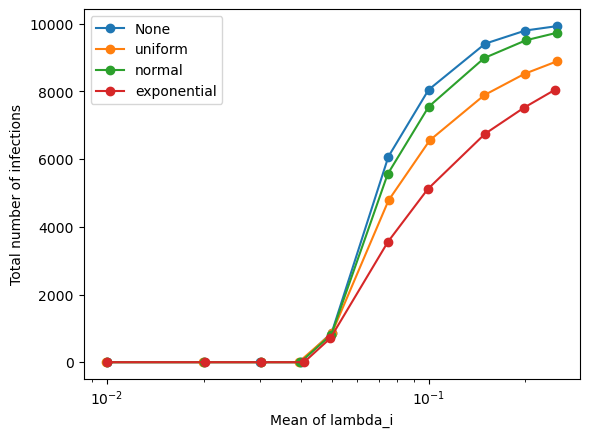

In [59]:
# plot

plt.figure()
for idx, dist in enumerate(dists):
    plt.plot(lambda_means_actual[idx], Nr_arys_theo[idx], 'o-', label=f"{dist}")
plt.xlabel("Mean of lambda_i")
plt.xscale("log")
plt.ylabel("Total number of infections")
plt.legend()
plt.show()

No impact on crit_thresholds.

Empirical:

In [65]:
Nr_arys_emp = np.zeros((len(dists), len(lambda_means)))
Nr_covs_emp = np.zeros((len(dists), len(lambda_means)))
iter_n = 100
for idx1, dist in enumerate(dists):
    print("processing dist: ", dist)
    Nr_ary_emp = Nr_arys_emp[idx1]
    Nr_cov_emp = Nr_covs_emp[idx1]
    lambda_mat = lambda_mats[idx1]

    for idx2, lambdas in enumerate(lambda_mat):

        cluster_size = np.zeros(iter_n)
        for itn in range(iter_n):
            print("iter: ", itn, '/', iter_n, end='\r')
            cluster_size[itn] = SIR_djset_dir(n, edge_ls, lambdas)
        Nr_ary_emp[idx2] = np.mean(cluster_size)
        Nr_cov_emp[idx2] = np.std(cluster_size) / Nr_cov_emp[idx2]
        print(f"Dist = {dist}, lambda_mean = {lambda_means[idx2]}, Nr = {Nr_ary_emp[idx2]}")

processing dist:  None
Dist = None, lambda_mean = 0.01, Nr = 1.15


C:\Users\Sun Ruitong\AppData\Local\Temp\ipykernel_24140\3096096572.py:17: RuntimeWarning: divide by zero encountered in scalar divide
  Nr_cov_emp[idx2] = np.std(cluster_size) / Nr_cov_emp[idx2]


Dist = None, lambda_mean = 0.02, Nr = 1.28
Dist = None, lambda_mean = 0.03, Nr = 1.53
Dist = None, lambda_mean = 0.04, Nr = 3.32
Dist = None, lambda_mean = 0.05, Nr = 24.32
Dist = None, lambda_mean = 0.075, Nr = 2201.56
Dist = None, lambda_mean = 0.1, Nr = 5398.08
Dist = None, lambda_mean = 0.15, Nr = 8081.39
Dist = None, lambda_mean = 0.2, Nr = 9304.88
Dist = None, lambda_mean = 0.25, Nr = 9530.74
processing dist:  uniform
Dist = uniform, lambda_mean = 0.01, Nr = 1.11
Dist = uniform, lambda_mean = 0.02, Nr = 1.23
Dist = uniform, lambda_mean = 0.03, Nr = 2.13
Dist = uniform, lambda_mean = 0.04, Nr = 3.27
Dist = uniform, lambda_mean = 0.05, Nr = 71.19
Dist = uniform, lambda_mean = 0.075, Nr = 3898.73
Dist = uniform, lambda_mean = 0.1, Nr = 4569.96
Dist = uniform, lambda_mean = 0.15, Nr = 7422.23
Dist = uniform, lambda_mean = 0.2, Nr = 7118.28
Dist = uniform, lambda_mean = 0.25, Nr = 7499.66
processing dist:  normal
Dist = normal, lambda_mean = 0.01, Nr = 1.09
Dist = normal, lambda_mean 

In [72]:
# Run a few more time for the exponential distribution
lambda_mat = lambda_mats[-1]

for idx2, lambdas in enumerate(lambda_mat):

    iter_n = 100
    cluster_size = np.zeros(iter_n)
    for itn in range(iter_n):
        print("iter: ", itn, '/', iter_n, end='\r')
        edge_ls = np.random.permutation(edge_ls) # Shuffle the edge list along the edge pair axis
        cluster_size[itn] = SIR_djset_dir(n, edge_ls, lambdas)
    Nr_arys_emp[-1, idx2] = np.mean(cluster_size)
    Nr_covs_emp[-1, idx2] = np.std(cluster_size) / Nr_arys_emp[-1, idx2]
    print(f"Dist = {dist}, lambda_mean = {lambda_means[idx2]}, Nr = {Nr_arys_emp[-1, idx2]}")

Dist = exponential, lambda_mean = 0.01, Nr = 1.05
Dist = exponential, lambda_mean = 0.02, Nr = 1.77
Dist = exponential, lambda_mean = 0.03, Nr = 1.95
Dist = exponential, lambda_mean = 0.04, Nr = 70.01
Dist = exponential, lambda_mean = 0.05, Nr = 73.92
Dist = exponential, lambda_mean = 0.075, Nr = 4776.52
Dist = exponential, lambda_mean = 0.1, Nr = 1713.18
Dist = exponential, lambda_mean = 0.15, Nr = 4032.47
Dist = exponential, lambda_mean = 0.2, Nr = 8079.3
Dist = exponential, lambda_mean = 0.25, Nr = 3725.77


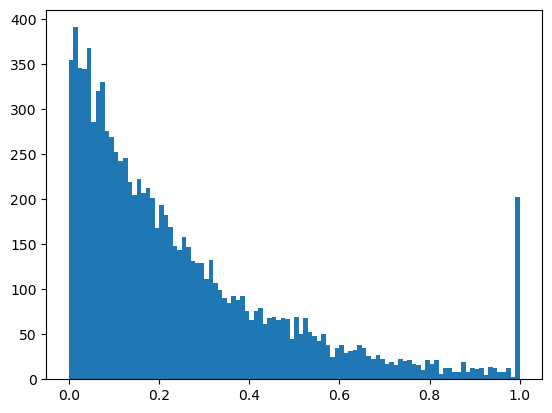

In [73]:
plt.hist(lambda_mat[-1], bins=100)
plt.show()

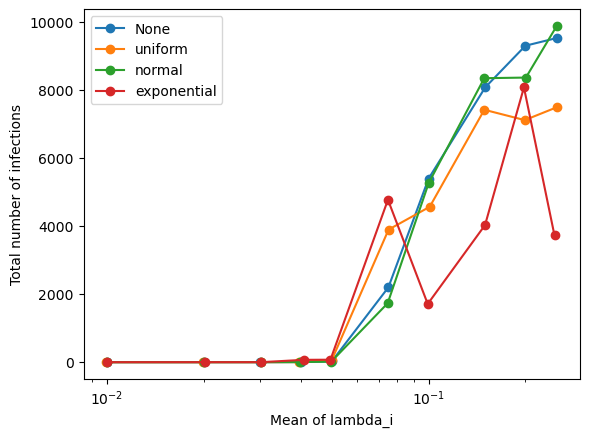

In [74]:
# plot
plt.figure()
for idx, dist in enumerate(dists):
    plt.plot(lambda_means_actual[idx], Nr_arys_emp[idx], 'o-', label=f"{dist}")
plt.xlabel("Mean of lambda_i")
plt.xscale("log")
plt.ylabel("Total number of infections")
plt.legend()
plt.show()